In [1]:
import pandas as pd
import networkx as nx
import datetime
from math import sqrt, pow
from matplotlib.pyplot import figure
from utils.data_generated import load_movie_metadata, load_title_crew
from utils.data_initial import load_cmu_character_metadata, load_imdb_name_basics

In [2]:
#https://towardsdatascience.com/from-dataframe-to-network-graph-bbb35c8ab675

In [3]:
START_DATE = pd.to_datetime(datetime.date(2000,1,1))
END_DATE = pd.to_datetime(datetime.date(2001,1,1))

In [4]:
movie_df = load_movie_metadata()
movie_df = movie_df.loc[(movie_df['release_date'] >= START_DATE) & (movie_df['release_date'] < END_DATE)]
movie_df.head()

,movie_id_wikipedia,movie_id_freebase,title_id_imdb,movie_name,release_date,box_office_revenue,runtime,languages,countries,is_adult,genres_cmu,genres_imdb
1038,12438366,/m/02w5vj3,tt14338824,Mehndi Waley Hath,2000-08-25,NaN,<NA>,[Punjabi language],[Pakistan],0,"[Romance Film, Drama]",[Drama]
1054,14494806,/m/03d57tv,tt0297034,A Boy Named Sue,2000-01-01,NaN,58.0,[English Language],[United States of America],0,"[Gender Issues, LGBT, Culture & Society, Biogr...",[Documentary]
1394,18496109,/m/04f57qz,tt0263362,The Stranger,2000-01-01,NaN,102.0,"[German Language, English Language, Spanish La...",[Austria],0,"[Crime Fiction, Drama]","[Crime, Drama]"
2116,14543900,/m/03d76w1,tt0271748,Raju Chacha,2000-12-20,NaN,163.0,[Hindi Language],[India],0,"[Drama, Comedy]","[Action, Comedy, Drama]"
3496,1226289,/m/04k12v,tt0163983,Bless the Child,2000-08-11,40443010.0,107.0,[English Language],"[United States of America, Germany]",0,"[Thriller, Mystery, Horror, Supernatural]","[Crime, Drama, Horror]"


In [5]:
char_df = load_cmu_character_metadata()
char_df = char_df.merge(movie_df, left_on='movie_id_wikipedia', right_on='movie_id_wikipedia', how='inner')[['title_id_imdb', 'actor_name']].dropna()
char_df.head()

,title_id_imdb,actor_name
0,tt14338824,Saima
1,tt14338824,Moammar Rana
2,tt14338824,Babar Ali
3,tt0263362,Nina Proll
4,tt0263362,Goya Toledo


In [6]:
crew_df = load_title_crew()
crew_df = crew_df.merge(movie_df, left_on='title_id', right_on='title_id_imdb', how='inner')[['title_id', 'directors', 'writers']]

#no need to filter because movie_df was already filtered and we did an inner join with it
#crew_df = crew_df.loc[(crew_df['release_date'] >= START_DATE) & (crew_df['release_date'] < END_DATE)]
#print(len(crew_df))

directors_df = crew_df[['title_id', 'directors']]
directors_df = directors_df.explode('directors').reset_index(drop=True)

writers_df = crew_df[['title_id', 'writers']]
writers_df = writers_df.explode('writers').reset_index(drop=True)

del crew_df

In [7]:
names_df = load_imdb_name_basics()[['person_name_id', 'person_name']]

directors_df = names_df.merge(directors_df, left_on='person_name_id', right_on='directors', how='inner')[['title_id', 'person_name_id', 'person_name']]

writers_df = names_df.merge(writers_df, left_on='person_name_id', right_on='writers')[['title_id', 'person_name_id', 'person_name']]

del names_df

In [8]:
BASE_SIZE = 1
BASE_ALPHA = 0.01
MUL_WEIGHT = 0.3
PARAMETER_WEIGHT = 0.9

In [9]:
#Create Empty Graph
G = nx.Graph()

#Add actors to the graph
for _, row in char_df.iterrows():
    actor = row['actor_name']

    movie_id = row['title_id_imdb']
        
    if not G.has_node(actor):
        G.add_node(actor, size=BASE_SIZE, alpha=BASE_ALPHA, movies={movie_id}, role='Actor', color='green')
    else:
        G.nodes[actor]['movies'].add(movie_id)
        G.nodes[actor]['size'] = G.nodes[actor]['size'] * 2

G.order()

4891

In [10]:
#Add directors to the graph
for _, row in directors_df.iterrows():
    director = row['person_name']

    movie_id = row['title_id']

    if not G.has_node(director):
        G.add_node(director, size=BASE_SIZE, alpha=BASE_ALPHA, movies={movie_id}, role='Director', color='red')
    else:
        G.nodes[director]['movies'].add(movie_id)
        G.nodes[director]['size'] = G.nodes[director]['size'] * 2

G.order()

5572

In [11]:
#Add writers to the graph
for _, row in writers_df.iterrows():
    writer = row['person_name']

    movie_id = row['title_id']

    if not G.has_node(writer):
        G.add_node(writer, size=BASE_SIZE, alpha=BASE_ALPHA, movies={movie_id}, role='Writer', color='blue')
    else:
        G.nodes[writer]['movies'].add(movie_id)
        G.nodes[writer]['size'] = G.nodes[writer]['size'] * 2

G.order()

6345

In [12]:
count = 0
for node1 in G.nodes(data='movies'):
    if count % 1000 == 0:
        print('Processed', count, '/', G.order(), 'nodes so far')
    count = count + 1
    name1 = node1[0]
    movies1 = node1[1]

    for node2 in G.nodes(data='movies'):
        name2 = node2[0]

        if not G.has_edge(name1, name2) and not name1 == name2:
            movies2 = node2[1]
            common_movies = movies1.intersection(movies2)
            
            if len(common_movies) > 0:
                G.add_edge(name1, name2, weight=len(common_movies) * MUL_WEIGHT)
                G.nodes[name1]['alpha'] = pow(G.nodes[name1]['alpha'], pow(PARAMETER_WEIGHT, len(common_movies)))
                G.nodes[name2]['alpha'] = pow(G.nodes[name2]['alpha'], pow(PARAMETER_WEIGHT, len(common_movies)))

print(G.order())
print(G.size())
print(G.size(weight='weight') / MUL_WEIGHT)

Processed 0 / 6345 nodes so far
Processed 1000 / 6345 nodes so far
Processed 2000 / 6345 nodes so far
Processed 3000 / 6345 nodes so far
Processed 4000 / 6345 nodes so far
Processed 5000 / 6345 nodes so far
Processed 6000 / 6345 nodes so far
6345
52044
52187.000000000306


In [13]:
# NUM_MOVIES = 400

# def create_actor_pairs(actors):
#     actor_pairs = []
#     for i in range(len(actors) - 1):
#         for j in range(i + 1, len(actors)):
#             actor_pairs.append((actors[i], actors[j]))
#     return actor_pairs

# count = 0
# actor_pairs_df = pd.DataFrame(columns=['Movie','Actor1','Actor2'])
# for _, row in movie_df.iterrows():
#     movie_name = row[2]
#     actors = character_df[character_df[0] == row[0]][8]
#     actor_pairs = create_actor_pairs(actors.tolist())
#     for actor_pair in actor_pairs:
#         if actor_pair[0] != actor_pair[1]:
#             actor_pair_df = pd.DataFrame([[movie_name, actor_pair[0], actor_pair[1]]], columns=['Movie','Actor1','Actor2'])
#             actor_pairs_df = pd.concat([actor_pairs_df, actor_pair_df], ignore_index = True)
#     if count == NUM_MOVIES:
#         break
#     count = count + 1
        
# print(len(movie_df))
# print(len(actor_pairs_df))
# actor_pairs_df.head()

In [14]:
# G = nx.Graph()
# G = nx.from_pandas_edgelist(actor_pairs_df, 'Actor1', 'Actor2')

{'Anthony LaPaglia': Text(-0.018087157979607582, -0.11448600888252258, 'Anthony LaPaglia'),
 'Devayani': Text(-0.41398191452026367, 0.1893375664949417, 'Devayani'),
 'Raghuvaran': Text(-0.32420653104782104, 0.1504935622215271, 'Raghuvaran'),
 'Mammootty': Text(-0.30097025632858276, 0.17111413180828094, 'Mammootty'),
 'Jagathi Sreekumar': Text(-0.39527472853660583, 0.09299126267433167, 'Jagathi Sreekumar'),
 'Mel Gibson': Text(0.09607332199811935, -0.04142099246382713, 'Mel Gibson'),
 'Helen Hunt': Text(0.0361967608332634, -0.08959291875362396, 'Helen Hunt'),
 'Marisa Tomei': Text(0.06851959228515625, -0.059938326478004456, 'Marisa Tomei'),
 'Rani Mukerji': Text(-0.31484052538871765, 0.2527243494987488, 'Rani Mukerji'),
 'Raveena Tandon': Text(-0.28085434436798096, 0.2954956591129303, 'Raveena Tandon'),
 'Jackie Shroff': Text(-0.29366081953048706, 0.29064399003982544, 'Jackie Shroff'),
 'Marlon Wayans': Text(0.16837526857852936, 0.011634047143161297, 'Marlon Wayans'),
 'Robert Miano': T

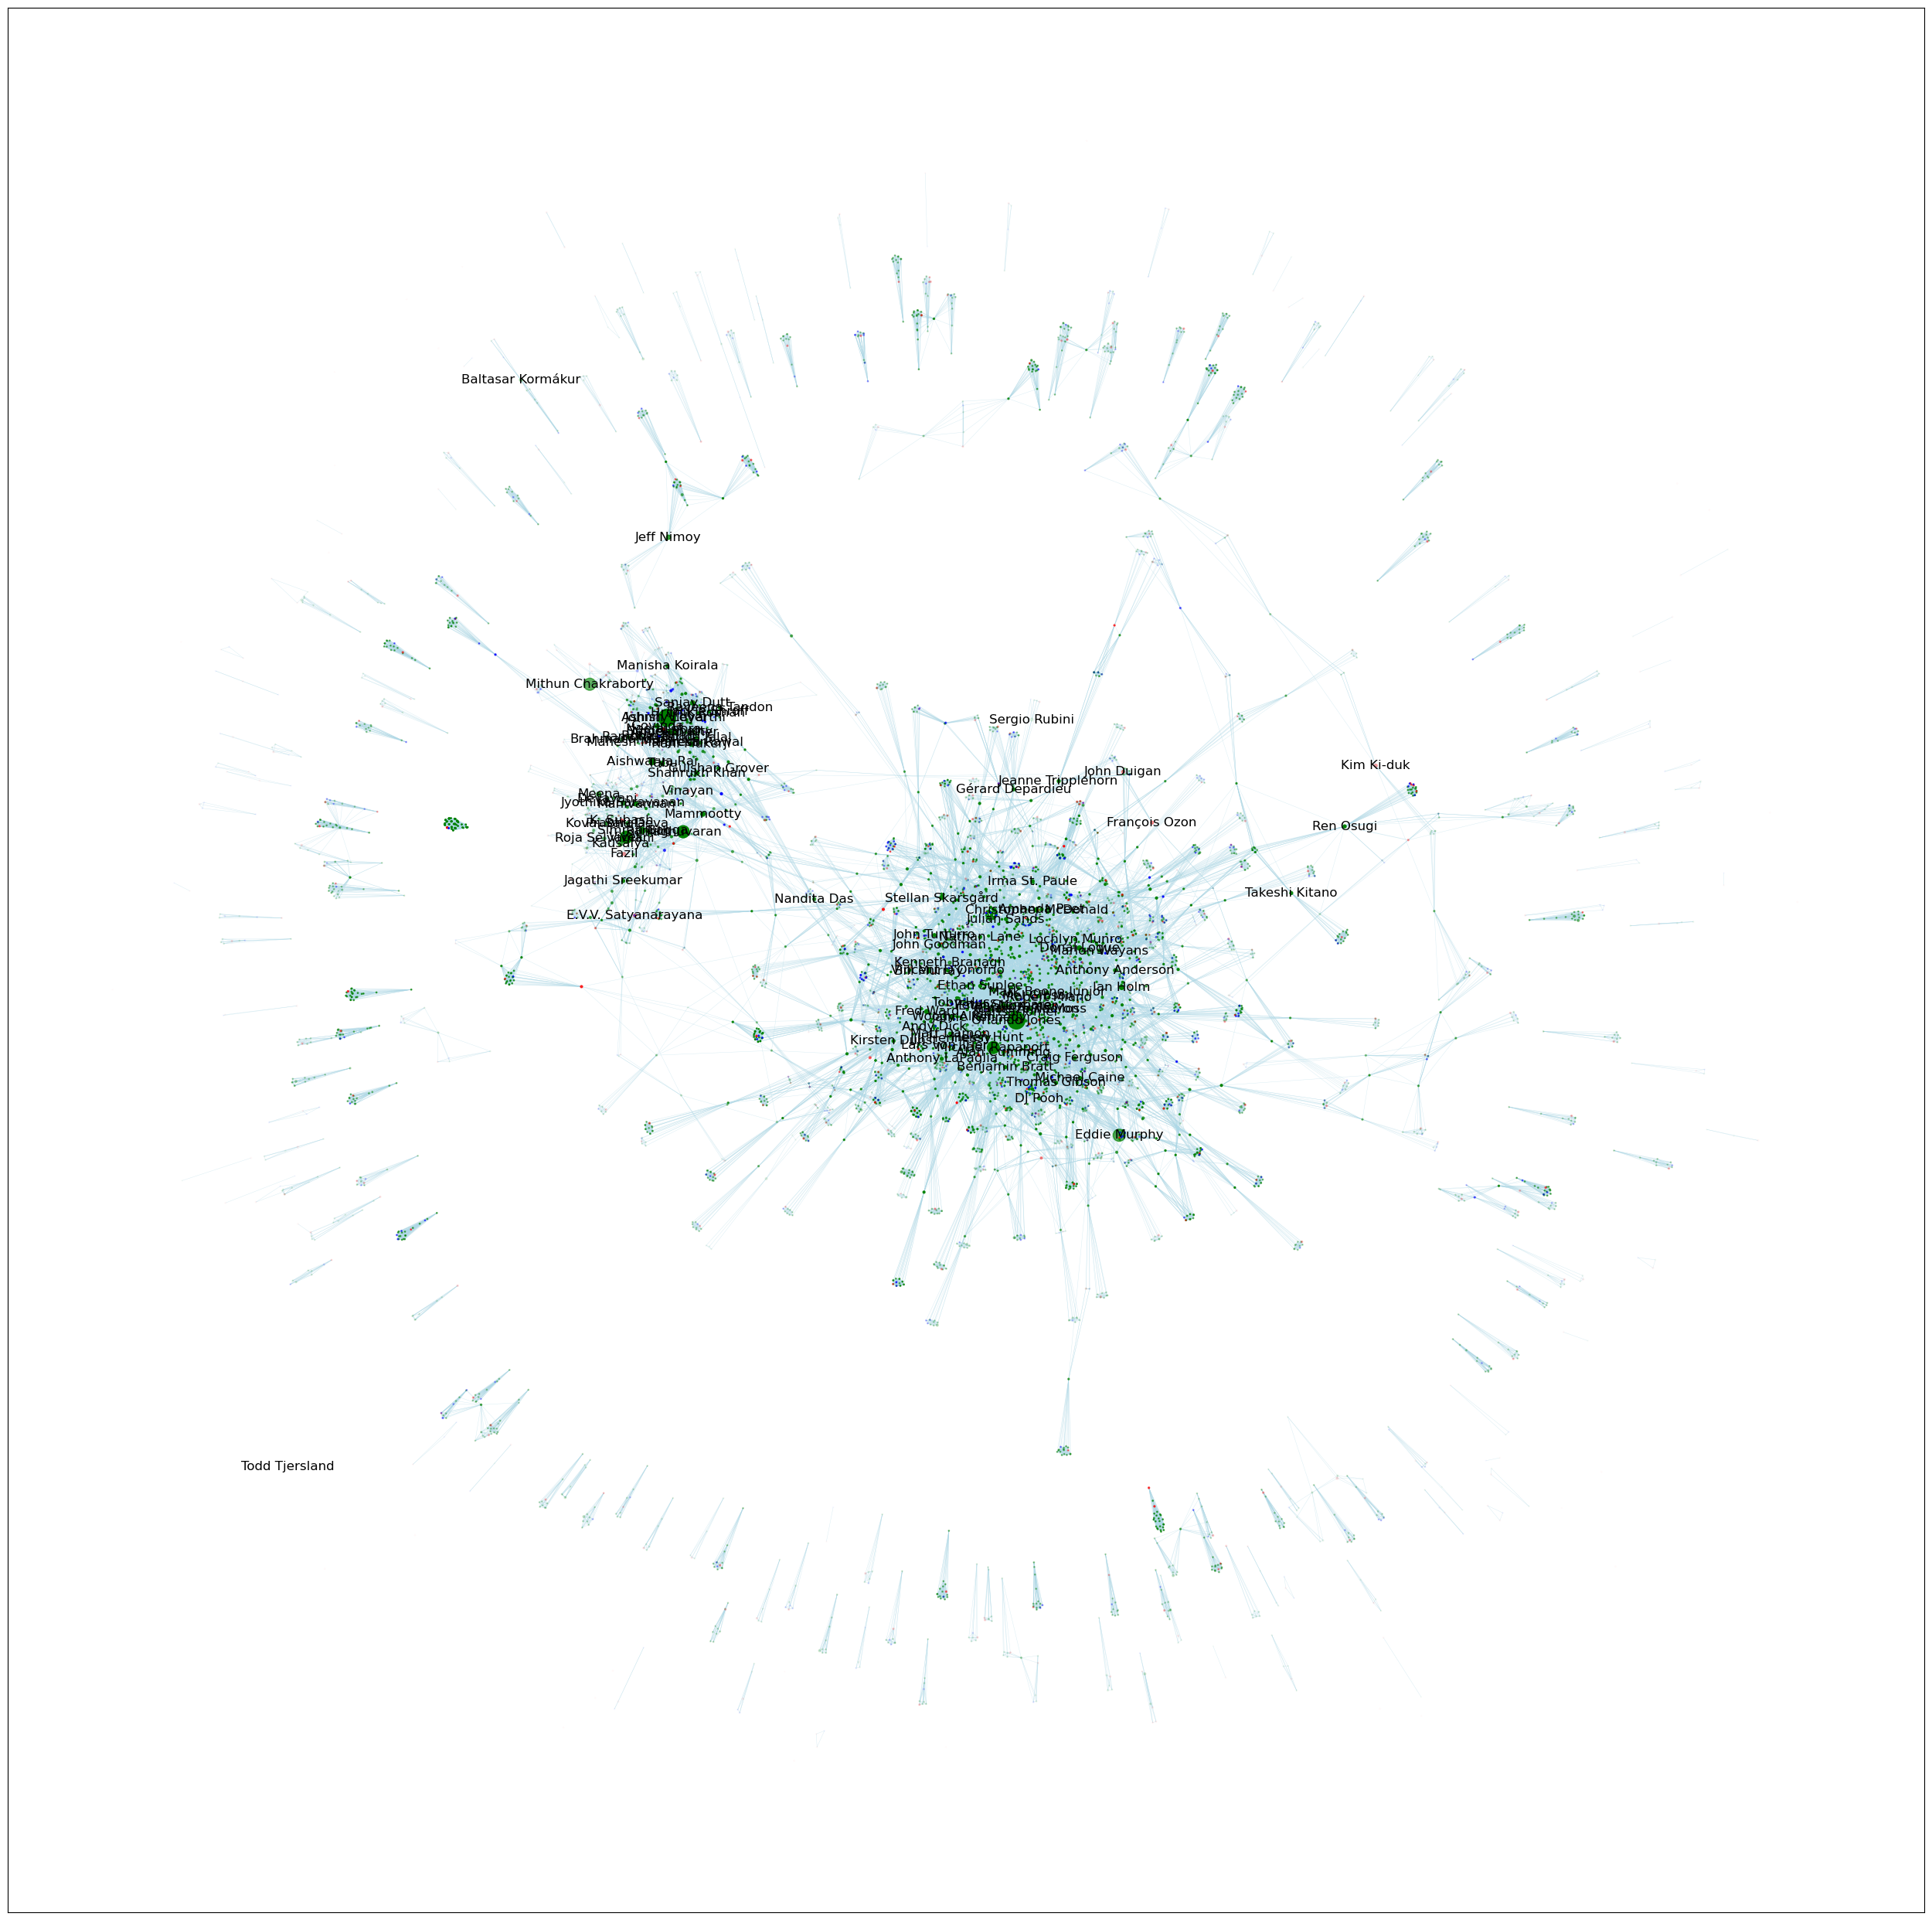

In [21]:
sizes = nx.get_node_attributes(G, 'size')
colors = nx.get_node_attributes(G, 'color')
alphas = nx.get_node_attributes(G, 'alpha')
weights = nx.get_edge_attributes(G, 'weight')
nodelist = G.nodes()
pos = nx.spring_layout(G, k=1.7/sqrt(G.order()))

figure(figsize=(32,32))

#print(weights)

nx.draw_networkx_nodes(G,pos,
                       nodelist=sizes.keys(),
                       node_size=list(sizes.values()),
                       node_color=list(colors.values()),
                       alpha=list(alphas.values()))
nx.draw_networkx_edges(G,pos,
                       edgelist=weights.keys(),
                       width=list(weights.values()),
                       edge_color='lightblue',
                       alpha=0.5)
big_nodes = []
for node in G.nodes(data='size'):
    if node[1] >= 32:
        big_nodes.append(node)
nx.draw_networkx_labels(G.subgraph(big_nodes), pos=pos,
                        labels={node[0]:node[0] for node in big_nodes}
                        #font_color='white'
                        )